In [1]:
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import train_test_split

## Cleaning and Arranging the data


### Define useful functions for cleaning the data

In [2]:
def remove_parentheses(string):
    pattern = r'\([^()]*\)'  # Matches "(...)" pattern
    while re.search(pattern, string):
        string = re.sub(pattern, '', string)
    return string.strip()

def format_ingredients(string):
    string = string.replace('.', '')  # Remove periods
    string = re.sub(r'\s*,\s*', ',', string)  # Remove spaces after commas
    ingredients_list = string.split(',')  # Split by comma
    formatted_ingredients = [ingredient.strip() for ingredient in ingredients_list]  # Remove leading/trailing spaces for each ingredient
    return ', '.join(formatted_ingredients)  # Join formatted ingredients with commas

def clean_text_values(df):
    text_columns = df.select_dtypes(exclude=[np.number]).columns
    for column in text_columns:
        if column == 'category':
            continue
        df[column].fillna('NA', inplace=True)
        df[column] = df[column].map(str.lower)
        if column == 'ingredients':
            df[column] = df[column].apply(remove_parentheses)
            df[column] = df[column].apply(format_ingredients)
        if column == 'household_serving_fulltext':
            df[column] = df[column].map(lambda x: re.sub('[^a-z]+', '', x))
    return df

### Read Data

In [3]:
food_train = pd.read_csv('data/food_train.csv')
food_test = pd.read_csv('data/food_test.csv')
food_nutrients = pd.read_csv('data/food_nutrients.csv')
nutrients_names = pd.read_csv('data/nutrients.csv')

In [4]:
clean_text_values(food_train)
nutrients = pd.merge(food_nutrients, nutrients_names, how='left',on='nutrient_id')
pivoted_nutrients = pd.pivot_table(nutrients, values='amount', index='idx', columns='name')
data = pd.merge(food_train, pivoted_nutrients, how='left', on='idx')

### Remove columns with > 0.8 nulls

In [5]:
cols_to_remove = data.columns[data.isnull().mean() > 0.8]
data = data.drop(columns=cols_to_remove)

df = data.copy()

### Splite the data

we'll split our df to train and test sets. Then, we'll split the train set into 2 data sets. One for feature engineering and the other for model tuning.

In [6]:
X = df.loc[:,df.columns != 'category']
y = df.loc[:,['category']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_fe, X_mt, y_fe, y_mt = train_test_split(X_train, y_train, test_size=0.5, random_state=42, stratify=y_train)
X_fe_train, X_fe_test, y_fe_train, y_fe_test = train_test_split(X_fe, y_fe, test_size=0.2, random_state=42)
X_mt_train, X_mt_test, y_mt_train, y_mt_test = train_test_split(X_mt, y_mt, test_size=0.2, random_state=42)

X_y_train = pd.merge(X_train, y_train, how="left",left_index=True, right_index=True)
X_y_train['idx'] = X_y_train['idx'].map(lambda x: str(x))
X_y_test = pd.merge(X_test, y_test, how="left",left_index=True, right_index=True)
X_y_test['idx'] = X_y_test['idx'].map(lambda x: str(x))

#### #### concat for eda
X_fe_w_cat = pd.merge(X_fe_train, y_fe_train, how="left",left_index=True, right_index=True)

### Enums

In [7]:
CANDY = 'candy'
COOKIES = 'cookies_biscuits'
CAKES = 'cakes_cupcakes_snack_cakes'
CHIPS_PRETZELS = 'chips_pretzels_snacks'
CHOCOLATE = 'chocolate'
POPCORN_PEANUTS = 'popcorn_peanuts_seeds_related_snacks'

CATEGORIES = [CANDY, COOKIES, CAKES, CHIPS_PRETZELS, CHOCOLATE, POPCORN_PEANUTS]

### Define useful functions

In [8]:
def better_name(df, col_name):
    df[col_name] = df[col_name].map(lambda x: str(x).translate(str.maketrans('', '', string.punctuation)))
    return(df)

def data_by_category(df, category):
    return df[df['category'] == category]

def get_most_popular_words(column):
    text = ', '.join(column.values)
    tokens = [word.strip() for word in text.split(',')]
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    word_counts = Counter(tokens)
    return word_counts

# Part 1 - Feature Engineering

### Top 10 words in each column in the data per category
Now we will find the most 10 common words in each column: 'description', 'ingredients' and 'household' per category. That will help us understand which words are represent and imply each category.

In [9]:
# Set Seaborn theme
sns.set_theme(style="whitegrid")

category_words = {}

for category, group in X_fe_w_cat.groupby('category'):
    category_words[category] = {
        'description': Counter(),
        'ingredients': Counter(),
        'household_serving_fulltext' : Counter(),
        'brand': Counter()
    }

    for _, row in group.iterrows():
        description_word_counts = get_most_popular_words(pd.Series([row['description']]))
        ingredients_word_counts = get_most_popular_words(pd.Series([row['ingredients']]))
        household_word_counts = get_most_popular_words(pd.Series([row['household_serving_fulltext']]))
        brand_word_counts = get_most_popular_words(pd.Series([row['brand']]))
        category_words[category]['description'] += description_word_counts
        category_words[category]['ingredients'] += ingredients_word_counts
        category_words[category]['household_serving_fulltext'] += household_word_counts
        category_words[category]['brand'] += brand_word_counts
    

# Plotting
def common_words_per_category_plot(category, col, x):
    # Words
    col_word_counts = category_words[category][col]
    col_top_words = col_word_counts.most_common(x)
    col_words, col_frequencies = zip(*col_top_words)

    plt.figure()
    plt.title(f"Top {x} words in {category} - {col}")
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    sns.barplot(x=list(col_words), y=list(col_frequencies))
    plt.xticks(rotation=45, fontsize=8)
    plt.tight_layout()
    plt.show()
    print(f'-The Top {x} most common words in "{category}" category in "{col}" column are: \n{col_words}')

### Most common words in selected column (brand/ ingredients/ description/ household) across categories


In [10]:
def most_common_words_per_column(col, x):
    # Find top common words across all categories
    common_words_counter = Counter()
    for words in category_words.values():
        common_words_counter += Counter(dict(words[col].most_common(x)))

    # Select top 10 common ingredients
    top_common_words = dict(common_words_counter.most_common(x))
    categories = list(category_words.keys())

    # Prepare data for the plot
    plot_data = []
    for word, count in top_common_words.items():
        row = []
        for category in categories:
            row.append(category_words[category][col][word])
        plot_data.append(row)

    # Plotting
    plt.figure(figsize=(10, 6))  # Adjust the figure size as desired
    plt.title(f'Top {x} Common {col.upper()} Across Categories')
    plt.xlabel("Category")
    plt.ylabel(col.upper())
    sns.heatmap(plot_data, cmap="Blues", annot=True, fmt='d', xticklabels=categories, 
                yticklabels=list(top_common_words.keys()), cbar=False)
    plt.xticks(fontsize=8)  # Adjust the x-axis label font size as desired
    plt.yticks(fontsize=8)  # Adjust the y-axis label font size as desired
    plt.tight_layout()
    plt.show()

#### We will use the results and graphs which created by the function above to select indicative words that describe in the best way  each column in each category.

For example: If there are words that repeate themself in at least 4 categories we will not use them.

# 'brand' column

### Find the TOP 15 Brands in each category
We will look over each category and find it's top 15 common brands.  After analyzing the results baised on the feature engineering train data set, we received the dict described above which includes brands for every category.

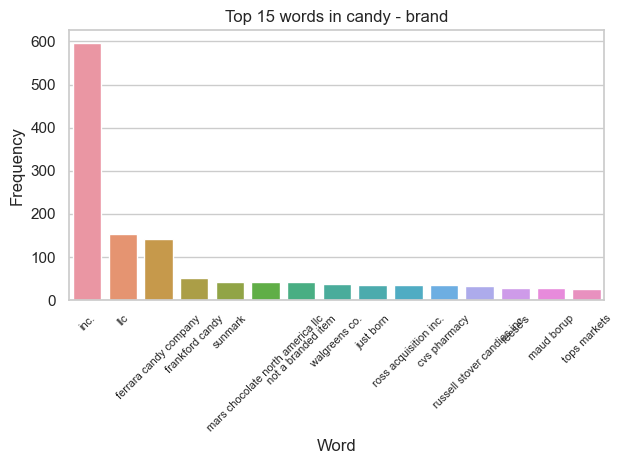

-The Top 15 most common words in "candy" category in "brand" column are: 
('inc.', 'llc', 'ferrara candy company', 'frankford candy', 'sunmark', 'mars chocolate north america llc', 'not a branded item', 'walgreens co.', 'just born', 'ross acquisition inc.', 'cvs pharmacy', 'russell stover candies inc.', "reese's", 'maud borup', 'tops markets')


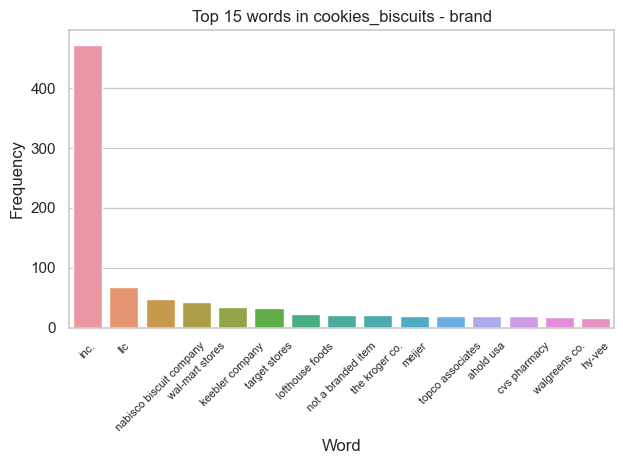

-The Top 15 most common words in "cookies_biscuits" category in "brand" column are: 
('inc.', 'llc', 'nabisco biscuit company', 'wal-mart stores', 'keebler company', 'target stores', 'lofthouse foods', 'not a branded item', 'the kroger co.', 'meijer', 'topco associates', 'ahold usa', 'cvs pharmacy', 'walgreens co.', 'hy-vee')


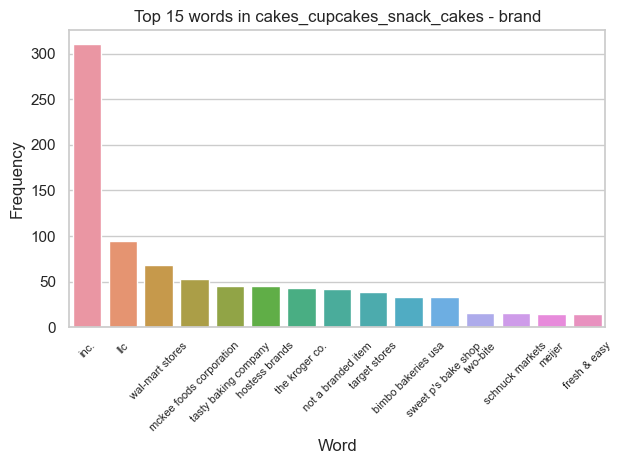

-The Top 15 most common words in "cakes_cupcakes_snack_cakes" category in "brand" column are: 
('inc.', 'llc', 'wal-mart stores', 'mckee foods corporation', 'tasty baking company', 'hostess brands', 'the kroger co.', 'not a branded item', 'target stores', 'bimbo bakeries usa', "sweet p's bake shop", 'two-bite', 'schnuck markets', 'meijer', 'fresh & easy')


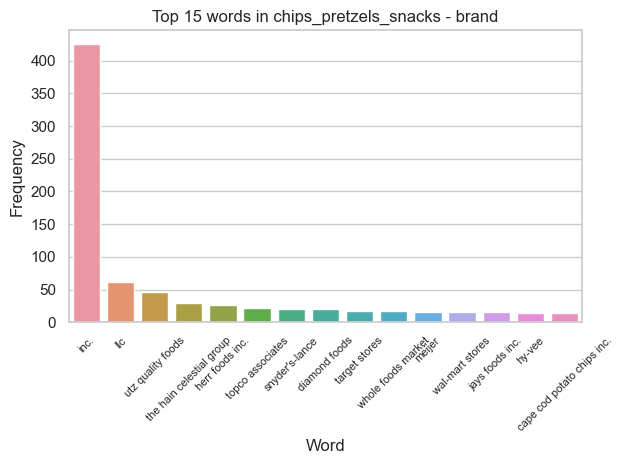

-The Top 15 most common words in "chips_pretzels_snacks" category in "brand" column are: 
('inc.', 'llc', 'utz quality foods', 'the hain celestial group', 'herr foods inc.', 'topco associates', "snyder's-lance", 'diamond foods', 'target stores', 'whole foods market', 'meijer', 'wal-mart stores', 'jays foods inc.', 'hy-vee', 'cape cod potato chips inc.')


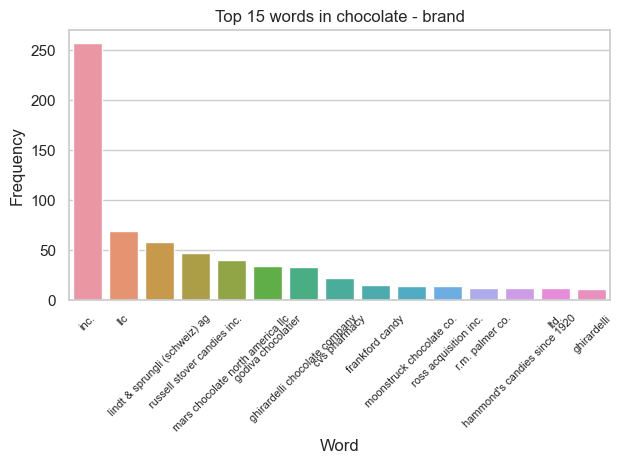

-The Top 15 most common words in "chocolate" category in "brand" column are: 
('inc.', 'llc', 'lindt & sprungli (schweiz) ag', 'russell stover candies inc.', 'mars chocolate north america llc', 'godiva chocolatier', 'ghirardelli chocolate company', 'cvs pharmacy', 'frankford candy', 'moonstruck chocolate co.', 'ross acquisition inc.', 'r.m. palmer co.', "hammond's candies since 1920", 'ltd.', 'ghirardelli')


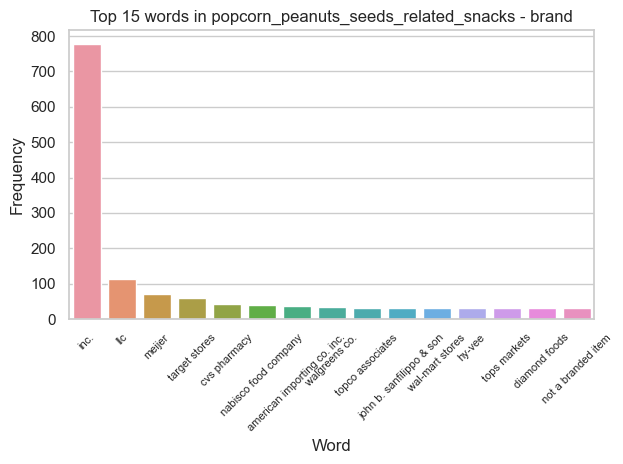

-The Top 15 most common words in "popcorn_peanuts_seeds_related_snacks" category in "brand" column are: 
('inc.', 'llc', 'meijer', 'target stores', 'cvs pharmacy', 'nabisco food company', 'american importing co. inc.', 'walgreens co.', 'topco associates', 'john b. sanfilippo & son', 'wal-mart stores', 'hy-vee', 'tops markets', 'diamond foods', 'not a branded item')


In [11]:
for category in CATEGORIES:
    common_words_per_category_plot(category, 'brand', 15)

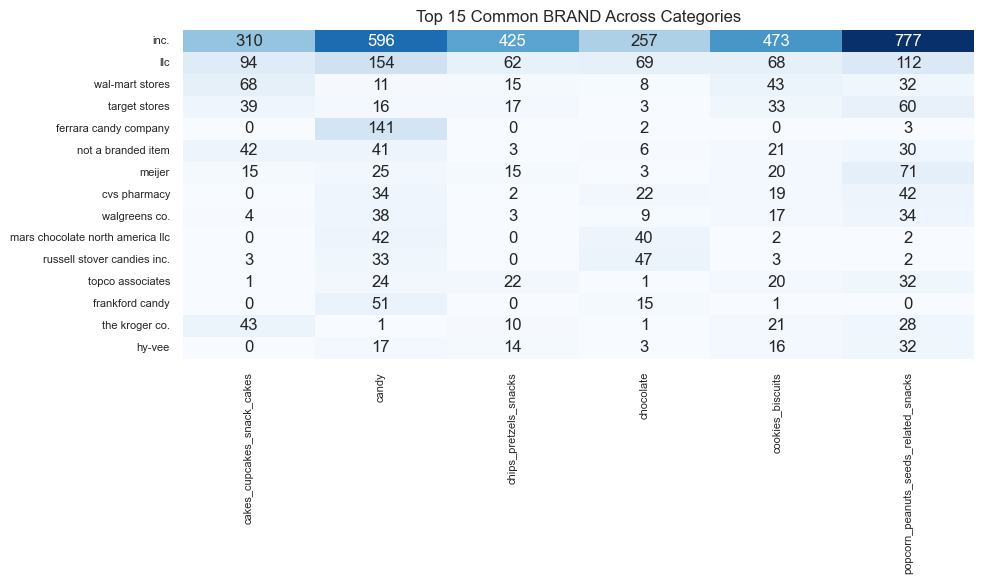

In [12]:
most_common_words_per_column('brand', 15)

In [13]:
brand_selected_words = {
    "candy": ["ferrara candy company", "frankford candy llc", "ross acquisition inc", "mars chocolate north america llc",
              "walgreens co", "russell stover candies inc", "just born inc", "sunmark", "jelly belly candy company",
              "holiday candy corp inc", "maud borup inc", "tops markets llc", "weis markets inc", "topco associates inc",
              "tootsie roll industries inc", "wm wrigley jr company", "reeses", "ahold usa inc"],
    "cookies": ["nabisco biscuit company", "target stores", "keebler company", "the kroger co", "lofthouse foods",
                "topco associates inc", "meijer inc", "ahold usa inc", "hyvee inc", "safeway inc", "walgreens co",
                "mckee foods corporation", "wegmans food markets inc", "kingston marketing co", "too good gourmet inc",
                "d f stauffer biscuit co inc", "abimar foods inc",],
    "cakes": ["mckee foods corporation", "bimbo bakeries usa inc", "tasty baking company", "the kroger co", 
              "hostess brands llc", "sweet ps bake shop", "meijer inc", "dawn food products inc", "flowers foods inc",
              "rich products corporation", "twobite", "schnuck markets inc", "fresh  easy", "dierbergs markets inc",
              "maplehurst bakeries llc", "rocky mountain pies", "the fathers table llc"],
    "chips_pretzels": ["utz quality foods inc", "the hain celestial group inc", "topco associates inc", "herr foods inc",
                       "meijer inc", "diamond foods inc", "hyvee inc", "target stores", "walmart stores inc", "snyderslance inc",
                       "inventure foods inc", "giant eagle inc", "good health natural products inc", "the kroger co",
                       "whole foods market inc", "old dutch foods inc", "jays foods inc", "cape cod potato chips inc",
                       "wise foods inc", "ahold usa inc"],
    "chocolate": ["lindt  sprungli schweiz ag", "russell stover candies inc", "mars chocolate north america llc",
                  "ghirardelli chocolate company", "godiva chocolatier inc", "ghirardelli", "fannie may confections inc",
                  "moonstruck chocolate co", "ross acquisition inc", "walgreens co", "rm palmer co", "frankford candy llc",
                  "theo chocolate inc", "hammonds candies since 1920 llc", "green  blacks", "alter eco americas inc",
                  "demets candy company", "whitmans candies inc", "european chocolate ltd"],
    "popcorn_peanuts": ["meijer inc", "target stores", "nabisco food company", "cvs pharmacy inc", "walgreens co",
                        "hyvee inc", "topco associates inc", "diamond foods inc", "ahold usa inc", "john b sanfilippo  son inc",
                        "american importing co inc", "giant eagle inc", "the kroger co", "supervalu inc", "tops markets llc",
                        "kar nut products company", "safeway inc", "whole foods market inc"],
}

# 'description' column

### Find the TOP 15 description words in each category
We will look over each category and find it's top 15 common description words. After analyzing the results baised on the feature engineering train data set, we received the dict described above which includes description words for every category.

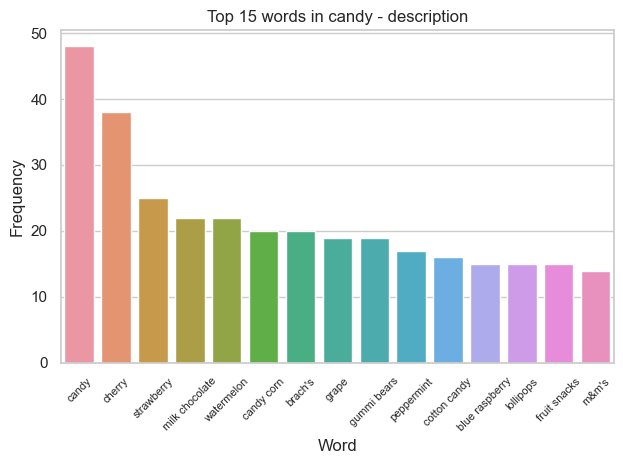

-The Top 15 most common words in "candy" category in "description" column are: 
('candy', 'cherry', 'strawberry', 'milk chocolate', 'watermelon', 'candy corn', "brach's", 'grape', 'gummi bears', 'peppermint', 'cotton candy', 'blue raspberry', 'lollipops', 'fruit snacks', "m&m's")


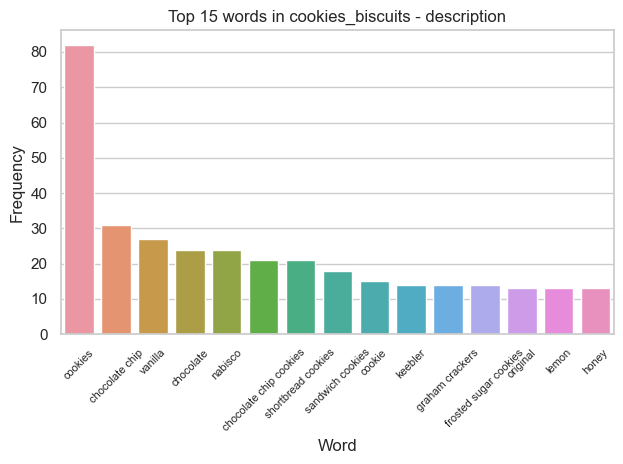

-The Top 15 most common words in "cookies_biscuits" category in "description" column are: 
('cookies', 'chocolate chip', 'vanilla', 'chocolate', 'nabisco', 'chocolate chip cookies', 'shortbread cookies', 'sandwich cookies', 'cookie', 'keebler', 'graham crackers', 'frosted sugar cookies', 'original', 'lemon', 'honey')


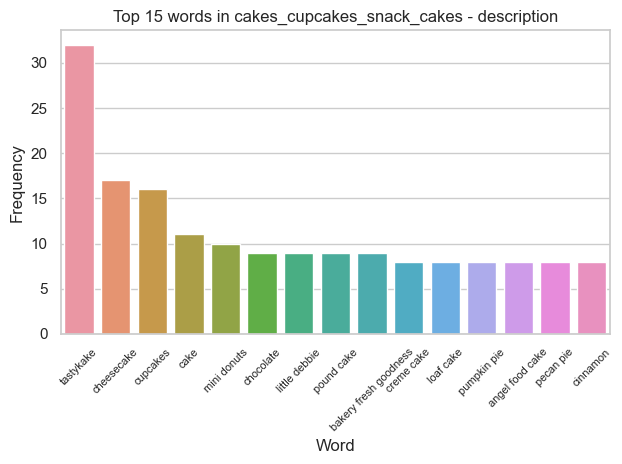

-The Top 15 most common words in "cakes_cupcakes_snack_cakes" category in "description" column are: 
('tastykake', 'cheesecake', 'cupcakes', 'cake', 'mini donuts', 'chocolate', 'little debbie', 'pound cake', 'bakery fresh goodness', 'creme cake', 'loaf cake', 'pumpkin pie', 'angel food cake', 'pecan pie', 'cinnamon')


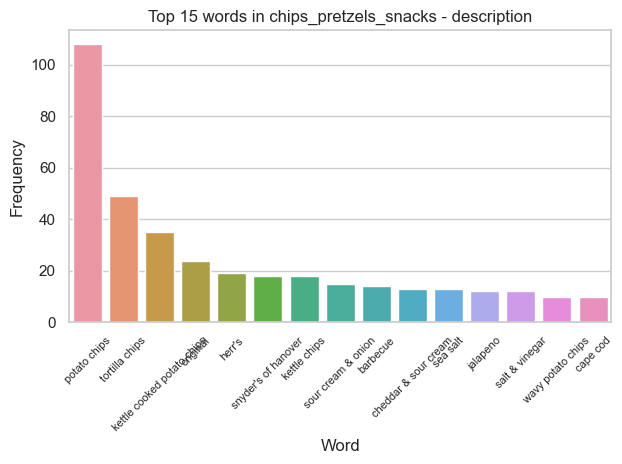

-The Top 15 most common words in "chips_pretzels_snacks" category in "description" column are: 
('potato chips', 'tortilla chips', 'kettle cooked potato chips', 'original', "herr's", "snyder's of hanover", 'kettle chips', 'sour cream & onion', 'barbecue', 'cheddar & sour cream', 'sea salt', 'jalapeno', 'salt & vinegar', 'wavy potato chips', 'cape cod')


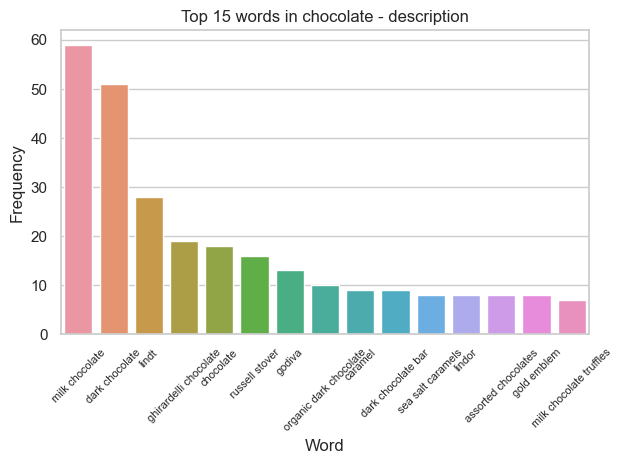

-The Top 15 most common words in "chocolate" category in "description" column are: 
('milk chocolate', 'dark chocolate', 'lindt', 'ghirardelli chocolate', 'chocolate', 'russell stover', 'godiva', 'organic dark chocolate', 'caramel', 'dark chocolate bar', 'sea salt caramels', 'lindor', 'assorted chocolates', 'gold emblem', 'milk chocolate truffles')


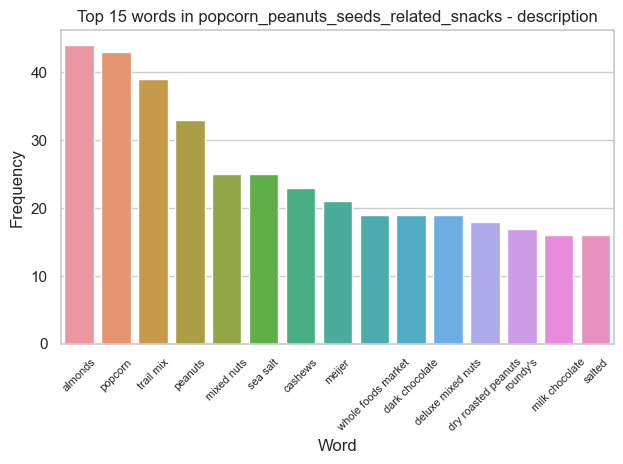

-The Top 15 most common words in "popcorn_peanuts_seeds_related_snacks" category in "description" column are: 
('almonds', 'popcorn', 'trail mix', 'peanuts', 'mixed nuts', 'sea salt', 'cashews', 'meijer', 'whole foods market', 'dark chocolate', 'deluxe mixed nuts', 'dry roasted peanuts', "roundy's", 'milk chocolate', 'salted')


In [14]:
for category in CATEGORIES:
    common_words_per_category_plot(category, 'description', 15)

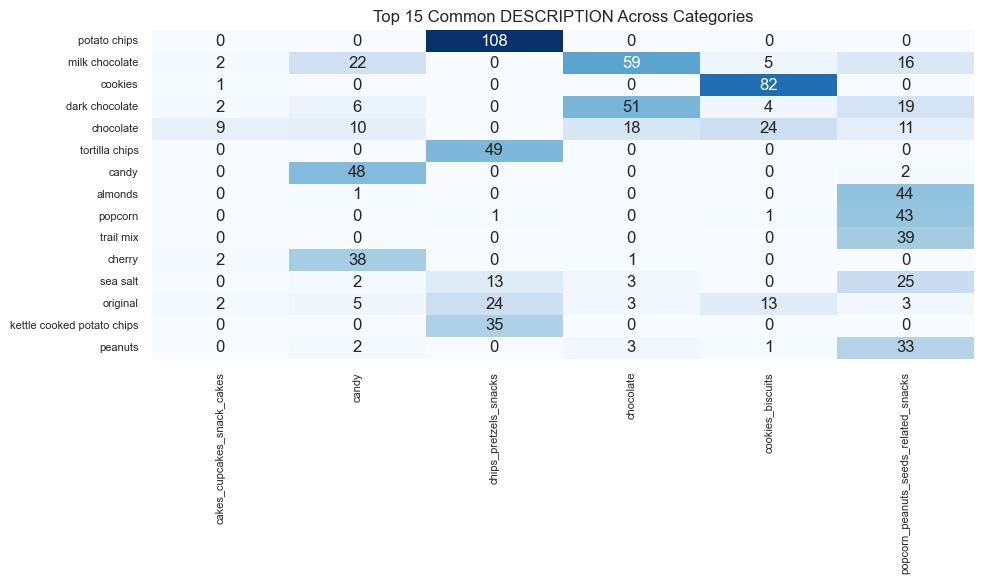

In [15]:
most_common_words_per_column('description', 15)

In [16]:
description_selected_words = {
    CAKES:['tastykake', 'cupcakes', 'cheezecake', 'bakery fresh goodness', 'apple pie', 'pie', 'pecan pie',
                                   'pumpkin pie', 'cake', 'cakes', 'cupcake', 'coffeecake', 'brownie', 'brownies', 'slice', 'sliced', 
                                    'torte', 'pies', 'donut', 'donuts', 'bakery'],
    CANDY:['candy', 'candies', 'gummy', 'gummi', 'gummies', 'twist', 'stick', 'marshmallow', 'marshmallows',
                       'jelly', 'snacks', "sweet's",  "brach's", 'cherry', 'strawberry', 'orange', 'watermelon', 
                       'peppermint', 'grape'],
    CHIPS_PRETZELS:['potato chips', 'tortilla chips', 'kettle cooked potato chips', 'sea salt', 'kettle chips', 
                               "snyder's of hanover", 'sour cream & onion', 'wavy potato chips', "herr's", 'chips', 'chip', 
                               'tortilla', 'crisps', 'crisp', 'potato', 'pretzel', 'pretzels', 'fries', 'corn'],
    CHOCOLATE:['dark chocolate', 'lindt', 'ghirardelli chocolate', 'russell stover', 'godiva', 'truffles', 
                          'dark chocolate bar', 'cocoa', 'praline', 'toffee', 'belgian', 'dark', 'truffle', 'chocolates'],
    COOKIES:['cookie', 'cookies', 'chocolate chip', 'chocolate chip cookies', 'sandwich cookies', 
                       'shortbread cookies', 'frosted sugar cookies', 'sugar cookies''crackers', 'frosted', 'wafer', 
                       'cracker', 'biscuit', 'macaroon', 'waffle'],
    POPCORN_PEANUTS:['popcorn', 'almond', 'almonds', 'trail mix', 'peanuts', 'mixed nuts', 
                                'dry roasted peanuts','cashews', 'kernel', 'shell', 'pecan']}

# 'ingredients' column

### Find the TOP 15 ingredients words in each category
We will look over each category and find it's top 15 common ingredients words. After analyzing the results baised on the feature engineering train data set, we received the dict described above which includes ingredients words for every category.

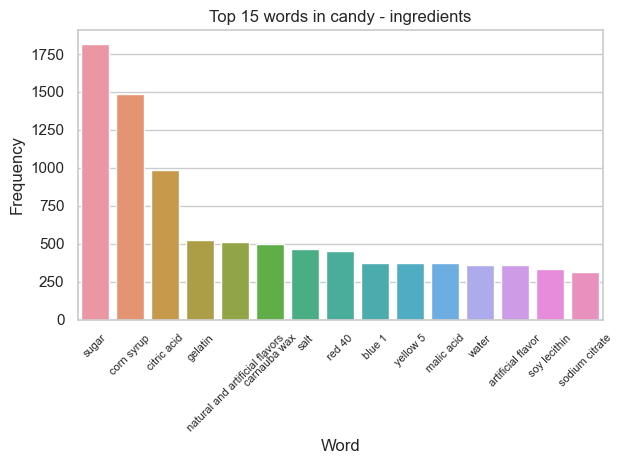

-The Top 15 most common words in "candy" category in "ingredients" column are: 
('sugar', 'corn syrup', 'citric acid', 'gelatin', 'natural and artificial flavors', 'carnauba wax', 'salt', 'red 40', 'blue 1', 'yellow 5', 'malic acid', 'water', 'artificial flavor', 'soy lecithin', 'sodium citrate')


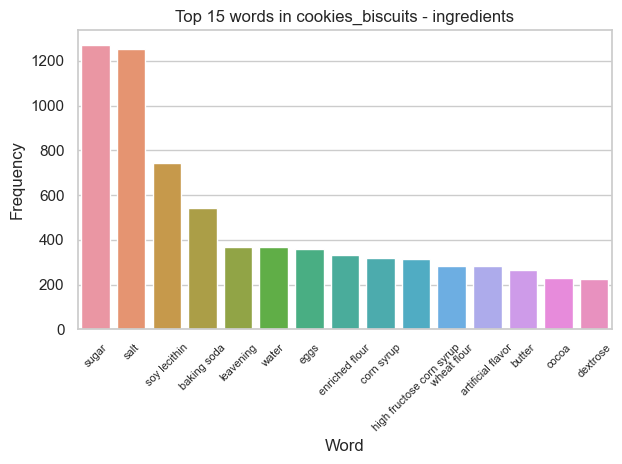

-The Top 15 most common words in "cookies_biscuits" category in "ingredients" column are: 
('sugar', 'salt', 'soy lecithin', 'baking soda', 'leavening', 'water', 'eggs', 'enriched flour', 'corn syrup', 'high fructose corn syrup', 'wheat flour', 'artificial flavor', 'butter', 'cocoa', 'dextrose')


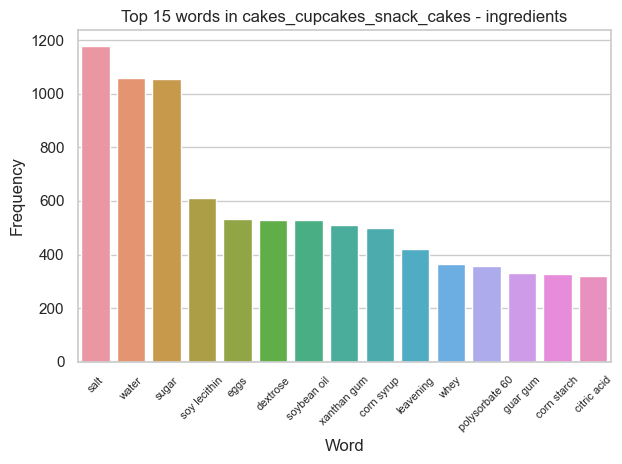

-The Top 15 most common words in "cakes_cupcakes_snack_cakes" category in "ingredients" column are: 
('salt', 'water', 'sugar', 'soy lecithin', 'eggs', 'dextrose', 'soybean oil', 'xanthan gum', 'corn syrup', 'leavening', 'whey', 'polysorbate 60', 'guar gum', 'corn starch', 'citric acid')


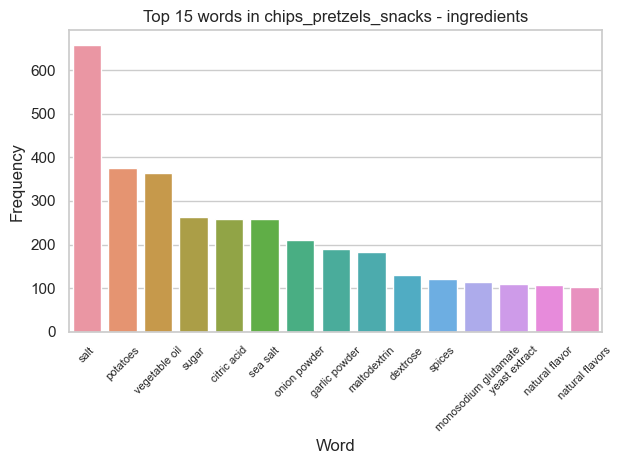

-The Top 15 most common words in "chips_pretzels_snacks" category in "ingredients" column are: 
('salt', 'potatoes', 'vegetable oil', 'sugar', 'citric acid', 'sea salt', 'onion powder', 'garlic powder', 'maltodextrin', 'dextrose', 'spices', 'monosodium glutamate', 'yeast extract', 'natural flavor', 'natural flavors')


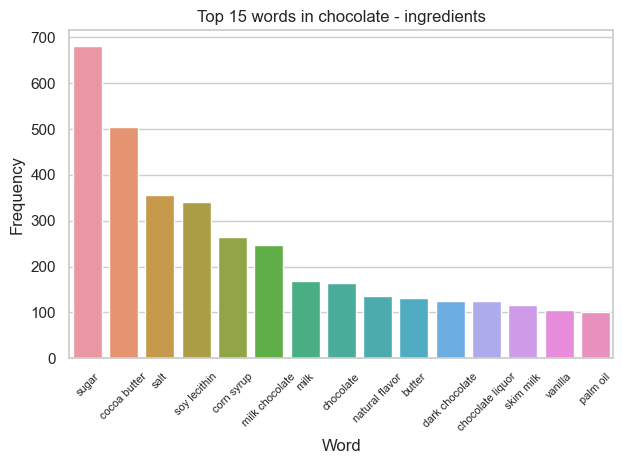

-The Top 15 most common words in "chocolate" category in "ingredients" column are: 
('sugar', 'cocoa butter', 'salt', 'soy lecithin', 'corn syrup', 'milk chocolate', 'milk', 'chocolate', 'natural flavor', 'butter', 'dark chocolate', 'chocolate liquor', 'skim milk', 'vanilla', 'palm oil')


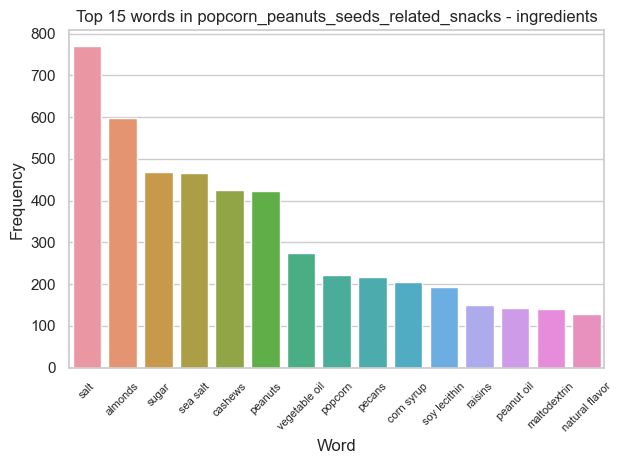

-The Top 15 most common words in "popcorn_peanuts_seeds_related_snacks" category in "ingredients" column are: 
('salt', 'almonds', 'sugar', 'sea salt', 'cashews', 'peanuts', 'vegetable oil', 'popcorn', 'pecans', 'corn syrup', 'soy lecithin', 'raisins', 'peanut oil', 'maltodextrin', 'natural flavor')


In [17]:
for category in CATEGORIES:
    common_words_per_category_plot(category, 'ingredients', 15)

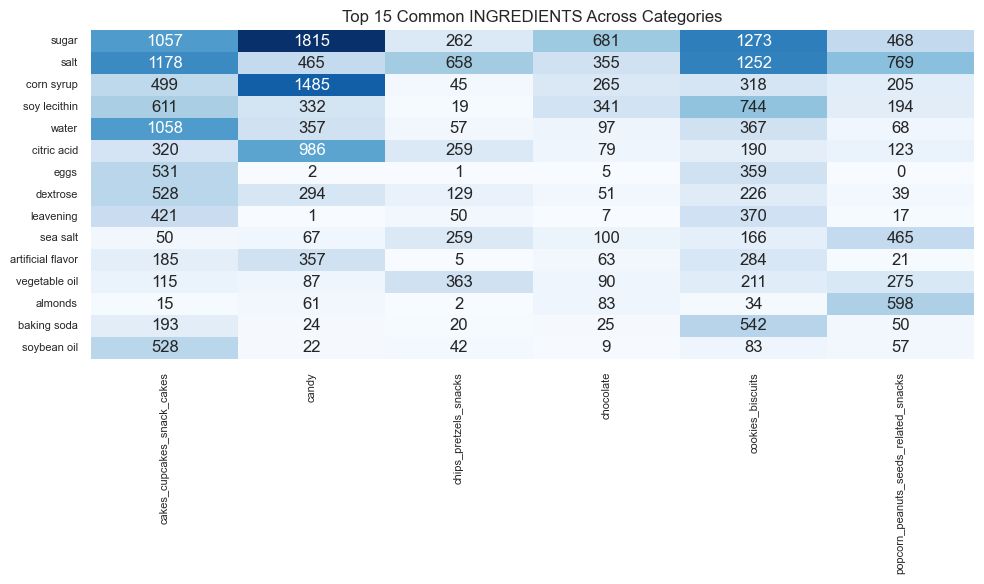

In [18]:
most_common_words_per_column('ingredients', 15)

In [19]:
ingredients_selected_words = {
    CAKES:['leavening', 'eggs'],
    CANDY:['gelatin', 'carnauba wax', 'red 40', 'blue 1'],
    CHIPS_PRETZELS:['potatoes', 'onion powder', 'garlic powder', 'maltodextrin', 'yeast extract'],
    CHOCOLATE:['cocoa butter', 'milk chocolate', 'chocolate', 'milk', 'dark chocolate', 'butter'],
    COOKIES:['baking soda', 'enriched flour', 'leavening', 'eggs'],
    POPCORN_PEANUTS:['almonds', 'peanuts', 'cashews', 'popcorn', 'pecans']
}

# 'household_serving_fulltext' column

Find the TOP 15 household words in each category¶
We will look over each category and find it's top 15 common description words. After analyzing the results baised on the feature engineering train data set, we received the dict described above which includes household words for every category.

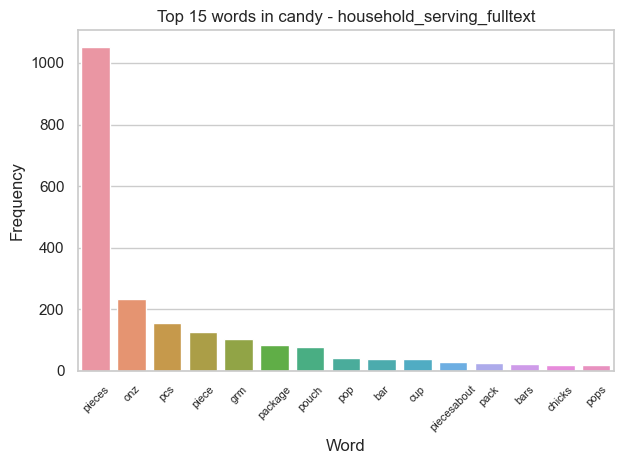

-The Top 15 most common words in "candy" category in "household_serving_fulltext" column are: 
('pieces', 'onz', 'pcs', 'piece', 'grm', 'package', 'pouch', 'pop', 'bar', 'cup', 'piecesabout', 'pack', 'bars', 'chicks', 'pops')


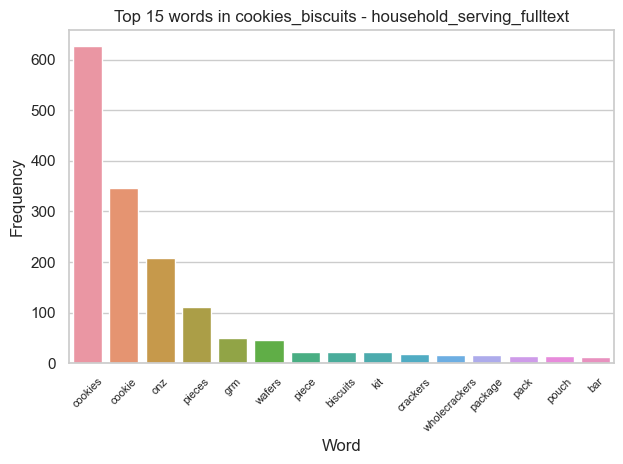

-The Top 15 most common words in "cookies_biscuits" category in "household_serving_fulltext" column are: 
('cookies', 'cookie', 'onz', 'pieces', 'grm', 'wafers', 'piece', 'biscuits', 'kit', 'crackers', 'wholecrackers', 'package', 'pack', 'pouch', 'bar')


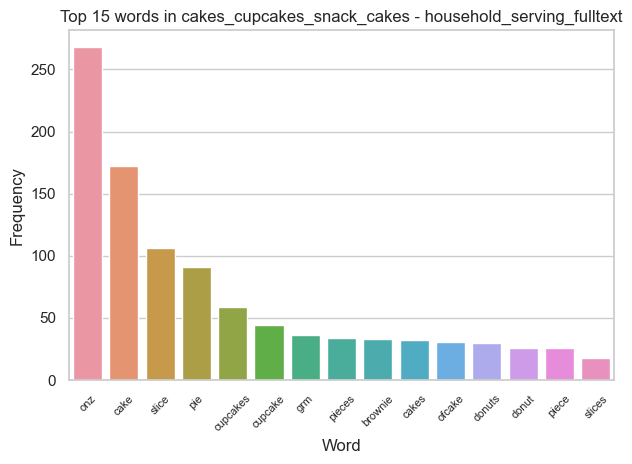

-The Top 15 most common words in "cakes_cupcakes_snack_cakes" category in "household_serving_fulltext" column are: 
('onz', 'cake', 'slice', 'pie', 'cupcakes', 'cupcake', 'grm', 'pieces', 'brownie', 'cakes', 'ofcake', 'donuts', 'donut', 'piece', 'slices')


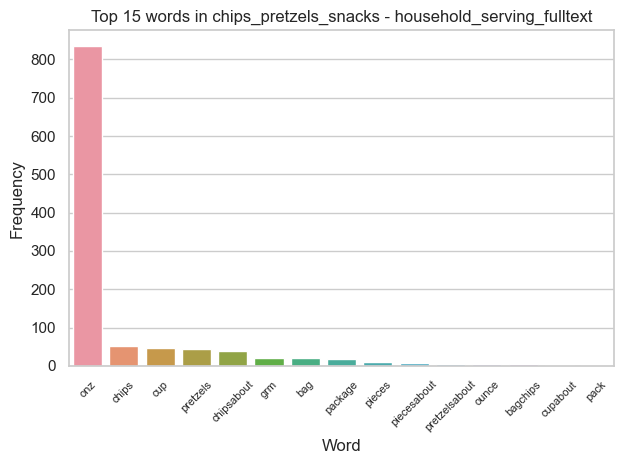

-The Top 15 most common words in "chips_pretzels_snacks" category in "household_serving_fulltext" column are: 
('onz', 'chips', 'cup', 'pretzels', 'chipsabout', 'grm', 'bag', 'package', 'pieces', 'piecesabout', 'pretzelsabout', 'ounce', 'bagchips', 'cupabout', 'pack')


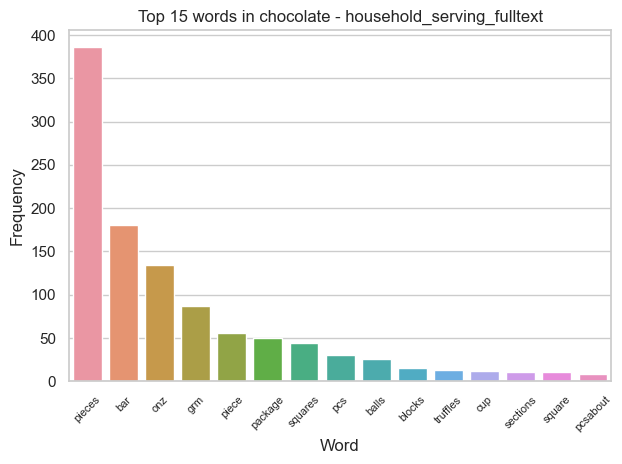

-The Top 15 most common words in "chocolate" category in "household_serving_fulltext" column are: 
('pieces', 'bar', 'onz', 'grm', 'piece', 'package', 'squares', 'pcs', 'balls', 'blocks', 'truffles', 'cup', 'sections', 'square', 'pcsabout')


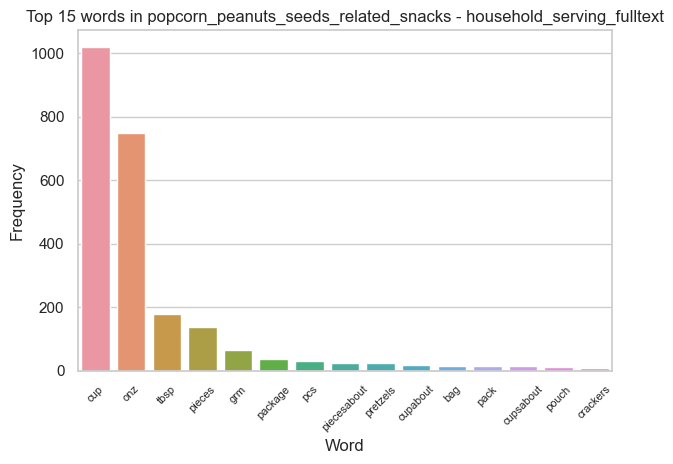

-The Top 15 most common words in "popcorn_peanuts_seeds_related_snacks" category in "household_serving_fulltext" column are: 
('cup', 'onz', 'tbsp', 'pieces', 'grm', 'package', 'pcs', 'piecesabout', 'pretzels', 'cupabout', 'bag', 'pack', 'cupsabout', 'pouch', 'crackers')


In [20]:
for category in CATEGORIES:
    common_words_per_category_plot(category, 'household_serving_fulltext', 15)

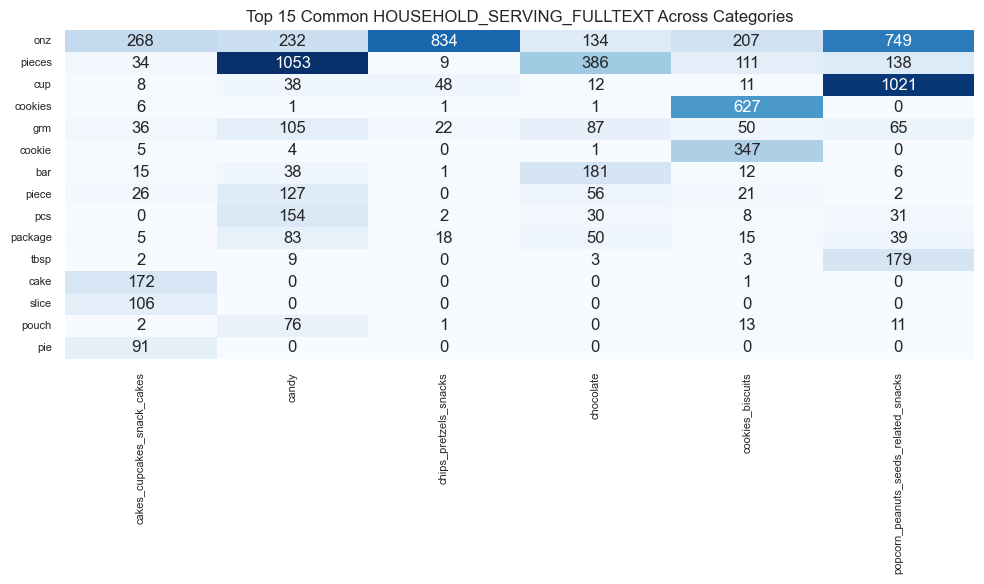

In [21]:
most_common_words_per_column('household_serving_fulltext', 15)

Notice that 'pretzels' word is common at chips_pretzels category and popcorn_peanuts so we decided not to use it. The same happend with 'chocolate' in some other categories.

In [22]:
household_selected_words = {
    CAKES:['cake', 'cakes', 'cupcakes', 'cupcake','brownie', 'pie', 'donut', 'muffin', 'tart', 
           'torte', 'doughnut','slice', 'pastry', 'bun', 'loaf'],
    CANDY:['candies', 'candy','gummies', 'gummy', 'marshmallow', 'pop', 'twist', 'stick','bear'],
    CHIPS_PRETZELS:['chip', 'chips', 'fries', 'crisp', 'chipsabout', 'pretzelsabout'],
    CHOCOLATE:['squares', 'square', 'balls', 'ball', 'truffle', 'praline', 'pralines', 'block', 'tablet', 'bar'],
    COOKIES:['cookies', 'cookie', 'wafers', 'wafer', 'crackers', 'cracker', 'biscuit', 'macaroon', 'waffle'],
    POPCORN_PEANUTS:['tbsp', 'kernel', 'popcorn', 'almond', 'shell', 'pecan']
}